# Taller de refuerzo de Keras (III)

Las arquitecturas *Convolutional LSTM* combinan técnicas de procesamiento de series temporales y de computer vision al introducir una celda recurrente convolucional en una capa LSTM. En este ejemplo, exploraremos un modelo Convolutional LSTM en una aplicación para la predicción de próximos fotogramas en un vídeo, es decir, el proceso de predecir qué frames de vídeo aparecerán tras una serie de frames pasados.

## Carga de librerías, módulos y funciones

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Carga de datos

In [11]:
# Descarga y carga el dataset
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

## Visualización

In [ ]:
# Muestra las dimensiones del dataset
# Deberías obtener (20, 10000, 64, 64), donde el primer valor corresponde al número de frames de cada vídeo,
# el segundo es el número de vídeos y los dos restantes son las dimensiones de cada frame.
# No se incluye el número de canales de color, lo que es una práctica habitual cuando las imágenes 
# se encuentran en grayscale.


Displaying frames for example 9.


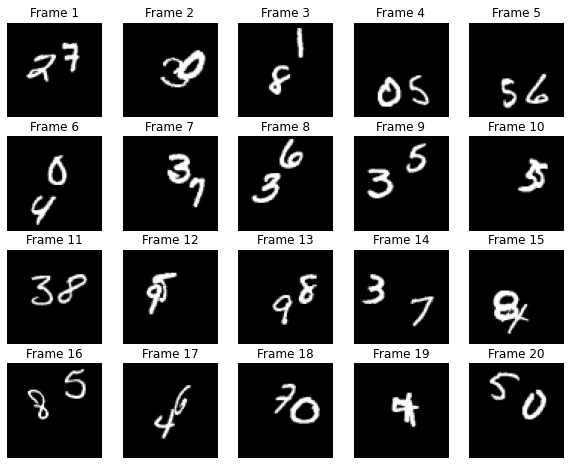

In [12]:
# Visualiza una muestra de frames
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# ,uestra cada una de las imágenes secuenciales de un vídeo escogido al azar
data_choice = np.random.choice(range(len(dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(dataset[data_choice][idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Muestra información junto a las figuras
print(f"Mostrando frames del vídeo {data_choice}.")
plt.show()

## Preprocesamiento

### Modificación de dimensiones

In [16]:
# Intercambia los ejes que representan el número de frames y el número de muestras de vídeos


In [ ]:
# Quédate con los 1000 primeros ejemplos para evitar problemas de memoria


In [ ]:
# Vuelve a mostrar las dimensiones del dataset
# Deberías obtener (1000, 20, 64, 64)


In [ ]:
# Añade una dimensión que corresponda a los canales de color (en este caso, 1 canal)


In [ ]:
# Vuelve a mostrar las dimensiones del dataset
# Deberías obtener (10000, 20, 64, 64, 1)


### Particiones de entrenamiento y validación

In [ ]:
# Divide los datos en un subconjunto de entrenamiento (80%) y otro de validaciónn (30%)
# En vez de usar Scikit Learn, vamos a utilizar la indexación clásica de Python. Para ello:
# a) Guarda los índices en una variable que se llame indexes


In [ ]:
# b) Mezcla los índices de forma aleatoria


In [ ]:
# c) Para el dataset de entrenamiento, quédate con el 80% de los índices


In [ ]:
# d) Para el dataset de validación, quédate con el 20% restante de los índices


In [ ]:
# e) Guarda la parte del dataset correspondiente a los índices de train


In [ ]:
# f) Guarda la parte del dataset correspondiente a los índices de val


### Escalado

In [ ]:
# Escala los datos de train y val a un rango 0-1


### Generación de target

In [22]:
# Definimos una función auxiliar para intercambiar los frames, donde
# `x` son los frames de 0 a n - 1, mientras que `y` son los frames de 1 a n.
def create_shifted_frames(data):
    X = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return X, y

In [23]:
# Aplica la función anterior a los dos subconjuntos de train y val, 
# con el fin de generar el target para cada uno de ellos.
# Guarda el resultado en 4 variables: X_train, y_train, X_val, y_val


In [ ]:
# Ejecuta esta celda y comprueba que obtienes el mismo resultado
# Dimensiones del dataset de entrenamiento: (800, 19, 64, 64, 1), (800, 19, 64, 64, 1)
# Dimensiones del dataset de validación: (200, 19, 64, 64, 1), (200, 19, 64, 64, 1)
print("Dimensiones del dataset de entrenamiento: " + str(X_train.shape) + ", " + str(y_train.shape))
print("Dimensiones del dataset de validación: " + str(X_val.shape) + ", " + str(y_val.shape))

## Definición del modelo

El modelo se llamará ConvLSTM_Model y estará compuesto por:

- Bloque 1:
  - Una capa ConvLSTM2D con 64 filtros de salida en la convolución, tamaño 5x5 de kernel convolucional, padding que añada ceros alrededor de cada frame, hiperparámetro return_sequences=True y activación ReLu. Recuerda que, al ser la primera capa, requiere que se especifique el tamaño de entrada de los datos (en este caso, input_shape = (None, *X_train.shape[2:])).
  
- Bloque 2:
  - Una operación de BatchNormalization (que se introduce como una capa adicional de Keras).
  - Una capa ConvLSTM2D con 64 filtros de salida en la convolución, tamaño 3x3 de kernel convolucional, padding que añada ceros alrededor de cada frame, hiperparámetro return_sequences=True y activación ReLu.

- Bloque 3
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una capa ConvLSTM2D con 64 filtros de salida en la convolución, tamaño 1x1 de kernel convolucional, padding que añada ceros alrededor de cada frame, hiperparámetro return_sequences=True y activación ReLu.

- Bloque 4
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una capa Conv3D con 256 filtros de salida en la convolución, tamaño 3 de kernel y activación ReLu.
  - Una operación de MaxPool3D (que se introduce como una capa adicional de Keras), con tamaño 2 de pool.

- Bloque 5
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una operación de GlobalAveragePooling3D (que también se introduce como una capa adicional de Keras).
  - Una capa densa de 512 unidades y activación ReLu.
  - Una operación de Dropout (que también se introduce como una capa adicional de Keras), con ratio 0.3.

- Capa de salida de tipo Conv3D, tamaño de filtro 1, tamaño de kernel convolucional 3x3x3, padding que añada ceros alrededor y una función de activación de tipo sigmoide.

In [39]:
# Define e instancia el modelo


In [40]:
# Muestra el modelo con el método summary()


Model: "ConvLSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, None, 64, 64, 64)  33024     
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, 64, 64, 1)   1729      
Total params: 746,689
Trainable params: 746,433
Non-trainable params: 256
____________________________________________

## Compilación del modelo

In [41]:
# Compila el modelo anterior, utilizando una pérdida de tipo binary_crossentropy, 
# y un optimizador de tipo Adam


## Ajuste del modelo

In [42]:
# Usaremos un callback de early stopping para mejorar el ajuste del modelo
# Fija la métrica de monitorización en val_loss y la paciencia en 10 epochs


In [43]:
# Fija los hiperparámetros de entrenamiento "epochs" y "batch_size" en 20 y 5, respectivamente


In [ ]:
# Muestra las dimensiones de X_train e y_train
print(X_train.shape)
print(y_train.shape)

In [ ]:
# Ajusta el modelo con el método fit() de Keras
# Introduce X_train e y_train
# Introduce el batch_size y las epochs
# Usa la partición de validación (X_val e y_val)
# Usa el callback de early stopping definido más arriba


## Predicciones de próximos frames

Con nuestro modelo ahora construido y entrenado, podemos generar algunas predicciones de fotogramas de ejemplo basadas en un nuevo vídeo.

Elegiremos un ejemplo aleatorio del conjunto de validación y luego utilizaremos sus primeros diez fotogramas. A partir de ahí, podemos permitir que el modelo prediga 10 nuevos fotogramas, que podemos comparar con los frames reales.


In [ ]:
# Elegimos un ejemplo al azar del set de validación


In [ ]:
# Nos quedamos con sus primeros 10 frames


In [ ]:
# Predecimos un nuevo grupo de 10 frames
for idx in range(10):
  
    # Extraemos la predicción del modelo y la postprocesamos
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Vamos concatenando los frames predichos
    frames = np.concatenate((frames, predicted_frame), axis=0)

In [ ]:
# Vamos a mostrar los frames originales y los predichos
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Frames originales
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Frames predichos
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

Finalmente, elegiremos algunos ejemplos del conjunto de validación y construiremos algunos GIF con ellos para ver los vídeos predichos por el modelo.

In [ ]:
# Escogemos 5 ejemplos de vídeos al azar
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

In [ ]:
# Iteramos sobre los vídeos y predecimos sus frames
predicted_videos = []

# Para cada vídeo:
for example in examples:

    # Nos quedamos con sus 10 primeros frames
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predecimos los siguientes 10 frames
    for i in range(10):

        # Extraemos la predicción del modelo y la postprocesamos
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Vamos almacenando los frames predichos
        new_predictions[i] = predicted_frame

    # Creamos y guardamos GIFs para cada pareja de frame real vs predicho
    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construimos un GIF a partir de los frames
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

In [ ]:
# Mostramos los vídeos
print(" Real\tPredicción")

for i in range(0, len(predicted_videos), 2):

    # Creamos y mostramos una `HBox` con el frame real y el predicho
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )

    # Mostramos la HBox
    display(box)